In [1]:
from tqdm import tqdm
import numpy as np
import torchaudio
import torch
import os
import wespeaker
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import subprocess
import sys 


In [2]:
def scan_directory_voxceleb1(test_dir):
    data = []
    for person_id in os.listdir(test_dir):
        person_path = os.path.join(test_dir, person_id)
        if os.path.isdir(person_path):
            for utterance_env in os.listdir(person_path):
                utterance_path = os.path.join(person_path, utterance_env)
                if os.path.isdir(utterance_path):
                    for file in os.listdir(utterance_path):
                        file_path = os.path.join(utterance_path, file)
                        if os.path.isfile(file_path):
                            # Assuming embedding is a placeholder for actual embedding extraction
                            embedding = "embedding_placeholder"
                            waveform, sample_rate = torchaudio.load(file_path)
                            duration = waveform.shape[1] / sample_rate
                            data.append(
                                [file_path, person_id, utterance_env, file, embedding, duration]
                            )

    df = pd.DataFrame(
        data,
        columns=[
            "path",
            "person_id",
            "utterance_env",
            "utterance_filename",
            "embedding",
            "duration",
        ],
    )
    return df


# Example usage
test_dir = "../data/vox1_test_wav"
df = scan_directory_voxceleb1(test_dir)

In [3]:
df.describe()

,duration
count,4874.000000
mean,8.275598
std,5.737056
min,3.960062
25%,4.880063
50%,6.480062
75%,9.400063
max,69.040063


In [14]:
def scan_directory_voxceleb2(test_dir):
    data = []
    for person_id in os.listdir(test_dir):
        person_path = os.path.join(test_dir, person_id)
        if os.path.isdir(person_path):
            for file in os.listdir(person_path):
                file_path = os.path.join(person_path, file)
                if os.path.isfile(file_path):
                    # Assuming embedding is a placeholder for actual embedding extraction
                    embedding = "embedding_placeholder"
                    waveform, sample_rate = torchaudio.load(file_path)
                    duration = waveform.shape[1] / sample_rate
                    data.append([file_path, person_id, file, embedding, duration])

    df = pd.DataFrame(
        data, columns=["path", "person_id", "utterance_filename", "embedding", "duration"]
    )
    return df


In [ ]:


# Example usage
test_dir = "../data/vox1_test_wav_windowed"
df = scan_directory_voxceleb2(test_dir)

In [ ]:
df.describe()

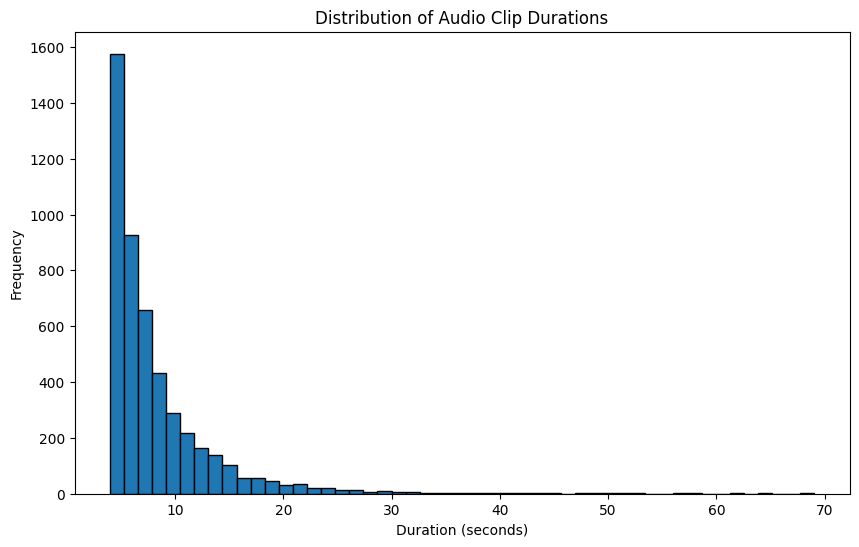

In [4]:
import matplotlib.pyplot as plt

# Function to load waveforms and calculate durations


# Load waveforms and calculate durations


# Plot the durations
plt.figure(figsize=(10, 6))
plt.hist(df['duration'], bins=50, edgecolor='black')
plt.title('Distribution of Audio Clip Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

In [5]:
df.describe()

,duration
count,4874.000000
mean,8.275598
std,5.737056
min,3.960062
25%,4.880063
50%,6.480062
75%,9.400063
max,69.040063


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4874 entries, 0 to 4873
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   path                4874 non-null   object 
 1   person_id           4874 non-null   object 
 2   utterance_env       4874 non-null   object 
 3   utterance_filename  4874 non-null   object 
 4   embedding           4874 non-null   object 
 5   duration            4874 non-null   float64
dtypes: float64(1), object(5)
memory usage: 228.6+ KB


In [6]:
window_size = 8
total_files = 0
for duration in df['duration']:
    num_windows = int(duration // window_size)
    if duration % window_size > 0:
        num_windows += 1
    total_files += num_windows

total_files

7085

In [10]:
from numpy import full


def repeat_to_max_len(data, max_len):
    """Repeat to a single wave to the specified length.

    Args:
        data: torch.Tensor (random len)
        max_len: maximum length to repeat or cut the data

    Returns:
        torch.Tensor (repeated to max_len)
    """
    data_len = data.shape[1]

    if data_len == 0:
        raise ValueError("data_len should not be zero")

    if data_len < max_len:
        repeats = max_len // data_len
        remainder = max_len % data_len
        data = torch.cat([data] * repeats, dim=1)
        if remainder > 0:
            data = torch.cat([data, data[:, :remainder]], dim=1)
    return data


def allign_dataframe_durations_celeb2(df, window_size, new_dataset_dir):
    if not os.path.exists(new_dataset_dir):
        os.makedirs(new_dataset_dir)

    new_data = []
    for index, row in df.iterrows():
        person_dir = os.path.join(new_dataset_dir, row["person_id"])
        if not os.path.exists(person_dir):
            os.makedirs(person_dir)

        waveform, sample_rate = torchaudio.load(row["path"])
        max_len = window_size * sample_rate  # 8 * 16000 = 128000

        # if it is less than 8 seconds - repeat to 8 seconds
        if waveform.shape[1] < max_len:
            waveform = repeat_to_max_len(waveform, max_len)
            file_name = f"{row["utterance_env"]}-{row['utterance_filename']}"
            full_path = os.path.join(person_dir, file_name) 
            torchaudio.save(full_path, waveform, sample_rate)
            new_data.append(
                [
                    full_path,
                    row["person_id"],
                    f"{row['utterance_filename']}.wav"
                ]
            )
        else:
            # if it is more, lets devide it into 8 second windows, and last one will be less than 8 seconds so repeat it to 8 seconds
            num_windows = waveform.shape[1] // max_len
            remainder = waveform.shape[1] % max_len

            for i in range(num_windows):
                start = i * max_len
                end = (i + 1) * max_len
                window = waveform[:, start:end]
                file_name = f"{row["utterance_env"]}-{row["utterance_filename"]}"
                file_name = file_name.replace(".wav", f"_{i}.wav")
                full_path = os.path.join(person_dir, file_name)
                torchaudio.save(full_path, window, sample_rate)
                new_data.append(
                    [
                        full_path,  
                        row["person_id"],
                        file_name
                    ]
                )
            if remainder > 0:
                start = max_len * num_windows
                end = waveform.shape[1]

                window = waveform[:, start:end]
                window = repeat_to_max_len(window, max_len)
                file_name = f"{row["utterance_env"]}-{row["utterance_filename"]}"
                file_name = file_name.replace(".wav", f"_{num_windows}.wav")
                full_path = os.path.join(person_dir, file_name)
                torchaudio.save(full_path, window, sample_rate)
                new_data.append(
                    [
                        full_path,
                        row["person_id"],
                        file_name
                    ]
                )

    new_df = pd.DataFrame(
        new_data,
        columns=["path", "person_id", "utterance_filename"],
    )
    return new_df


# Example usage
window_size = 8
new_dataset_dir = "../data/vox1_test_wav_windowed"
new_df = allign_dataframe_durations_celeb2(df, window_size, new_dataset_dir)

## TODO if you do not specify environment dirs it will override files....

In [11]:
new_df.head(20)

,path,person_id,utterance_filename
0,../data/vox1_test_wav_windowed/id10295/nt7dNRv...,id10295,00005.wav.wav
1,../data/vox1_test_wav_windowed/id10295/nt7dNRv...,id10295,00004.wav.wav
2,../data/vox1_test_wav_windowed/id10295/nt7dNRv...,id10295,nt7dNRvlEHE-00001_0.wav
3,../data/vox1_test_wav_windowed/id10295/nt7dNRv...,id10295,nt7dNRvlEHE-00001_1.wav
4,../data/vox1_test_wav_windowed/id10295/nt7dNRv...,id10295,00003.wav.wav
5,../data/vox1_test_wav_windowed/id10295/nt7dNRv...,id10295,nt7dNRvlEHE-00002_0.wav
6,../data/vox1_test_wav_windowed/id10295/nt7dNRv...,id10295,nt7dNRvlEHE-00002_1.wav
7,../data/vox1_test_wav_windowed/id10295/NkqrS8y...,id10295,00005.wav.wav
8,../data/vox1_test_wav_windowed/id10295/NkqrS8y...,id10295,00004.wav.wav
9,../data/vox1_test_wav_windowed/id10295/NkqrS8y...,id10295,00001.wav.wav


In [12]:
new_df.info()
unique_paths = new_df['path'].unique()
len(unique_paths)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7085 entries, 0 to 7084
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   path                7085 non-null   object
 1   person_id           7085 non-null   object
 2   utterance_filename  7085 non-null   object
dtypes: object(3)
memory usage: 166.2+ KB


7085

In [15]:
after_allign_df_path = "../data/vox1_test_wav_windowed"
after_allign_df = scan_directory_voxceleb2(after_allign_df_path)

In [16]:
after_allign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7085 entries, 0 to 7084
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   path                7085 non-null   object 
 1   person_id           7085 non-null   object 
 2   utterance_filename  7085 non-null   object 
 3   embedding           7085 non-null   object 
 4   duration            7085 non-null   float64
dtypes: float64(1), object(4)
memory usage: 276.9+ KB


In [17]:
after_allign_df.describe()

,duration
count,7085.0
mean,8.0
std,0.0
min,8.0
25%,8.0
50%,8.0
75%,8.0
max,8.0
